In [95]:
# init the model
from langchain.chat_models import init_chat_model

model_name = "gpt-5-nano"
prompt = "Hello"

llm = init_chat_model(model=model_name)

In [96]:
llm.invoke(prompt)

AIMessage(content='Hi there! How can I help today? I can answer questions, explain concepts, help with writing or coding, brainstorm ideas, plan projects, or just chat. Let me know what you’d like to do.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 244, 'prompt_tokens': 7, 'total_tokens': 251, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-Cyyg8GAcryygtUzS2LRsqYAp3psGo', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bcbb1-7596-7320-a2e5-5e040e5cd65b-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 7, 'output_tokens': 244, 'total_tokens': 251, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_to

In [97]:
# Email Router - classifty the input email ["respond", "ignore", "notify"]
# Email Input 
email_input = {
    "from" : "user@gmail.com",
    "to" : "netflix@support.com",
    "subject": "Netflix Account Unable to Access",
    "thread" : """Dear Netflix Support Team,

I hope this message finds you well. I am writing to report an issue I am currently experiencing with my Netflix account.

Issue: Unable to Access Account

I have been unable to access my Netflix account recently. When I attempt to log in, I encounter difficulties that prevent me from accessing the service.

Could you please assist me in resolving this matter? I would appreciate any guidance on:
- Steps to regain access to my account
- Verification of my account status
- Any security concerns that might be affecting my access

I am available to provide any additional information you may need to help resolve this issue promptly.

Thank you for your attention to this matter. I look forward to your response.
"""
}
 

In [98]:
from rich.markdown import Markdown
Markdown(email_input["thread"])

Dear Netflix Support Team,                                                                                         

I hope this message finds you well. I am writing to report an issue I am currently experiencing with my Netflix    
account.                                                                                                           

Issue: Unable to Access Account                                                                                    

I have been unable to access my Netflix account recently. When I attempt to log in, I encounter difficulties that  
prevent me from accessing the service.                                                                             

Could you please assist me in resolving this matter? I would appreciate any guidance on:                           

 • Steps to regain access to my account                                                                            
 • Verification of my account status                                                                               
 • Any security concerns that might be affecting my access                                                         

I am available to provide any additional information you may need to help resolve this issue promptly.             

Thank you for your attention to this matter. I look forward to your response.

In [99]:
from pydantic import BaseModel, Field
from typing import Literal
class RouterSchema(BaseModel):
    """Analyse the email and classify route it based on the content"""
    reasoning : str = Field(description="Step by Step analysis of the email")
    classification : Literal["ignore", "notify", "respond"] = Field(description="Classify the email based on the content")
    


In [100]:
llm_wth_router = llm.with_structured_output(RouterSchema)

In [101]:
email_input 

{'from': 'user@gmail.com',
 'to': 'netflix@support.com',
 'subject': 'Netflix Account Unable to Access',
 'thread': 'Dear Netflix Support Team,\n\nI hope this message finds you well. I am writing to report an issue I am currently experiencing with my Netflix account.\n\nIssue: Unable to Access Account\n\nI have been unable to access my Netflix account recently. When I attempt to log in, I encounter difficulties that prevent me from accessing the service.\n\nCould you please assist me in resolving this matter? I would appreciate any guidance on:\n- Steps to regain access to my account\n- Verification of my account status\n- Any security concerns that might be affecting my access\n\nI am available to provide any additional information you may need to help resolve this issue promptly.\n\nThank you for your attention to this matter. I look forward to your response.\n'}

In [102]:
from email_assistant.template import parse_email
sender, to, subject, thread = parse_email(emial_input)


In [103]:
from email_assistant.util_one import user_prompt

u_prompt =user_prompt.format(sender=sender, to=to, subject=subject, thread=thread)

In [104]:
Markdown(u_prompt)

Please detremine how to handle this email                                                                          

Sender : user@gmail.com Receiver : netflix@support.com Subject : Netflix Account Unable to Access Thread : Dear    
Netflix Support Team,                                                                                              

I hope this message finds you well. I am writing to report an issue I am currently experiencing with my Netflix    
account.                                                                                                           

Issue: Unable to Access Account                                                                                    

I have been unable to access my Netflix account recently. When I attempt to log in, I encounter difficulties that  
prevent me from accessing the service.                                                                             

Could you please assist me in resolving this matter? I would appreciate any guidance on:                           

 • Steps to regain access to my account                                                                            
 • Verification of my account status                                                                               
 • Any security concerns that might be affecting my access                                                         

I am available to provide any additional information you may need to help resolve this issue promptly.             

Thank you for your attention to this matter. I look forward to your response.

In [105]:
llm_wth_router.invoke(u_prompt).classification

'respond'

In [106]:
from langgraph.graph import MessagesState

class State(MessagesState):
    email_input :dict
    classification_decision: Literal["ignore","respond", "notify"]

In [107]:
from langgraph.graph import END
from langgraph.types import Command
def traige_router(state:State):
    email_input = state["email_input"]
    sender, to, subject, thread = parse_email(emial_input)
    u_prompt =user_prompt.format(sender=sender, to=to, subject=subject, thread=thread)
    response = llm_wth_router.invoke(u_prompt)

    if response.classification =="ignore":
        goto = END
        update = {
            "classification_decision" : "ignore"
        }
    elif response.classification =="notify":
        goto = END
        update = {
            "classification_decision" : "notify"
        }
    elif response.classification =="respond":
        goto = "response-agent"
        update = {
            "classification_decision" : "respond",
            "messages": {
                "role": "user",
                "content": u_prompt
               
            }
        }
    else: 
        return ValueError("Invalid value found")

    return Command(goto=goto, update=update)


    

In [108]:
from langchain.tools import tool

@tool
def send_email(sender:str, to:str, subject:str, thread:str):
    """Send an email"""
    return f"Email has been send to : {to}"

In [109]:
llm = llm.bind_tools([send_email], tool_choice="any",  parallel_tool_calls=False)

In [ ]:
from langgraph.graph import START, END, MessagesState, StateGraph

def call_llm(state:State):
    return {"messages" : llm.invoke(state["messages"])} ## tooll call


def tool_handler(state:State):
     args = state["messages"][-1].tool_calls[0]["args"]
     out = send_email.invoke(args)
     return {"messages": out}
    

def should_continue(state:State):
    if state["messages"][-1].tool_calls:
        return "tool_handler"
    else:
        return END

    

agent = StateGraph(State)
agent.add_node("call_llm", call_llm)
agent.add_node("tool_handler", tool_handler)

agent.add_edge(START, "call_llm")

agent.add_conditional_edges("call_llm", should_continue, {"tool_handler":"tool_handler", END:END})

# agent.add_edge("tool_handler", "call_llm")

agent = agent.compile()



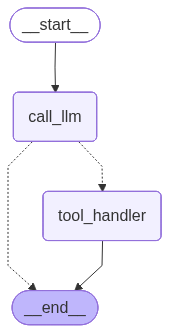

In [119]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [112]:
agent.invoke({"messages": "Hello"})

{'messages': [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='50696bda-fad8-4ff7-b158-54a88c321a5a'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 490, 'prompt_tokens': 135, 'total_tokens': 625, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 448, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CyygSQlnnlHpb2ev4FkwsWP4HhTQT', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bcbb1-c5db-7862-b71d-305bfa3877ab-0', tool_calls=[{'name': 'send_email', 'args': {'sender': 'support@example.com', 'to': 'user@example.com', 'subject': 'Hello from Support', 'thread': 'greeting'}, 'id': 'call_aPMt3LvmHOxCyjXlgYcludiD', 'type': 'tool_call'}], i

In [122]:
agent_wworkflow = (
    StateGraph(State)
    .add_node("traige_router", traige_router)
    .add_node("response-agent", agent)
    .add_edge(START, "traige_router")
    .add_edge("traige_router", "response-agent")
)

agent_workflow = agent_wworkflow.compile()

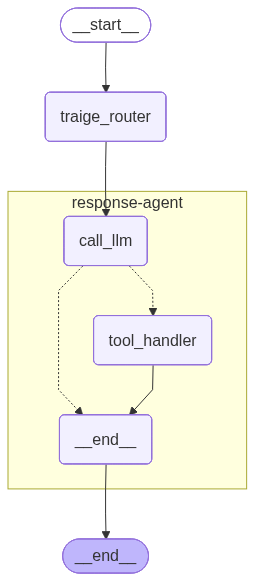

In [123]:
display(Image(agent_workflow.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
agent_workflow.invoke({"email_input": email_input})